# Extended Kalman Filter for Constant Turn Rate and Velocity (CTRV) Vehicle Model

In [185]:
import numpy as np
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos

%matplotlib inline
fw = 10 # figure width

![Extended Kalman Filter Step](resources/Extended-Kalman-Filter-Step.png)



Where $w_k$ and $v_k$ are the process and observation noises which are both assumed to be zero mean Multivariate Gaussian noises with covariance matrix $Q$ and $R$ respectively.

The function $g$ can be used to compute the predicted state from the previous estimate and similarly the function $h$ can be used to compute the predicted measurement from the predicted state. However, $g$ and $h$ cannot be applied to the covariance directly. Instead a matrix of partial derivatives (the Jacobian matrix) is computed.

At each time step, the Jacobian is evaluated with current predicted states. These matrices can be used in the Kalman filter equations. This process essentially linearizes the non-linear function around the current estimate.

### Sensor setup:
- velocity sensor: $v$ in $\psi$
- yaw rate sensor: $\dot \psi$
- GPS: $x$ & $y$

## State Vector - Constant Turn Rate and Velocity Vehicle Model (CTRV)

Constant Turn Rate, Constant Velocity Model for a vehicle ![CTRV Model](resources/CTRV-Model.png)

$$x_k= \left[ \matrix{ x \\ y \\ \psi \\ v \\ \dot\psi} \right] = \left[ \matrix{ \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate}} \right]$$

In [186]:
numstates=5 # States

The IMU acquires data with 50Hz, the GPS sensor just with 10Hz, so we only have a position correction every 5th Kalman filter cycle.

In [187]:
dt = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS=1.0/10.0 # Sample Rate of GPS is 10Hz

In [188]:
vs, psis, dpsis, dts, xs, ys, lats, lons = symbols('v \psi \dot\psi T x y lat lon')

gs = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [psis+dpsis*dts],
             [vs],
             [dpsis]])
state = Matrix([xs,ys,psis,vs,dpsis])
state

Matrix([
[       x],
[       y],
[    \psi],
[       v],
[\dot\psi]])

## Dynamic Matrix

### This formulas calculate how the state is evolving from one to the next time step

In [189]:
gs

Matrix([
[x + v*(-sin(\psi) + sin(T*\dot\psi + \psi))/\dot\psi],
[ y + v*(cos(\psi) - cos(T*\dot\psi + \psi))/\dot\psi],
[                                   T*\dot\psi + \psi],
[                                                   v],
[                                            \dot\psi]])

### No linear model!
To linearize the model, linearization is needed.
Since we have a more-dimensional state, we need the Jacobian.
The Jacobian is the matrix of all first-order partial derivatives.

### Calculate the Jacobian of the Dynamic Matrix with respect to the state vector to linearize the state transition

![Jacobian](resources/Jacobian.png)

In [190]:
gs.jacobian(state)

Matrix([
[1, 0, v*(-cos(\psi) + cos(T*\dot\psi + \psi))/\dot\psi, (-sin(\psi) + sin(T*\dot\psi + \psi))/\dot\psi, T*v*cos(T*\dot\psi + \psi)/\dot\psi - v*(-sin(\psi) + sin(T*\dot\psi + \psi))/\dot\psi**2],
[0, 1, v*(-sin(\psi) + sin(T*\dot\psi + \psi))/\dot\psi,  (cos(\psi) - cos(T*\dot\psi + \psi))/\dot\psi,  T*v*sin(T*\dot\psi + \psi)/\dot\psi - v*(cos(\psi) - cos(T*\dot\psi + \psi))/\dot\psi**2],
[0, 0,                                                1,                                              0,                                                                                         T],
[0, 0,                                                0,                                              1,                                                                                         0],
[0, 0,                                                0,                                              0,                                                                                         1]])

## Initial Uncertainty $P_0$

[[1000.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.]
 [   0.    0.    0. 1000.    0.]
 [   0.    0.    0.    0. 1000.]] 



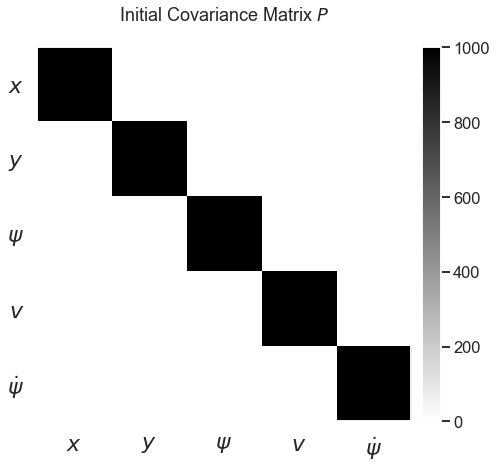

In [191]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0, 1000.0])
print(P, "\n")

fig = plt.figure(figsize=(7, 7))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$ \n')
ylocs, ylabels = plt.yticks()

# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
plt.rcParams["axes.grid"] = False

# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Process Noise Covariance Matrix Q

### Process covariances are determined by estimating the maximum possible change of a state during one cycle.

In [192]:
sGPS      = 0.5 * 7.0 * dt ** 2  # assume 7m/s2 as maximum acceleration
sCourse   = 0.1 * dt # assume 0.1rad/s as maximum turn rate
sVelocity = 7.0 * dt # assume 7.0m/s2 as maximum acceleration
sYaw      = 1.0 * dt # assume 1.0rad/s2 as the maximum turn rate acceleration

Q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sYaw**2])
print(Q)

[[1.96e-06 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.96e-06 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 4.00e-06 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.96e-02 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.00e-04]]


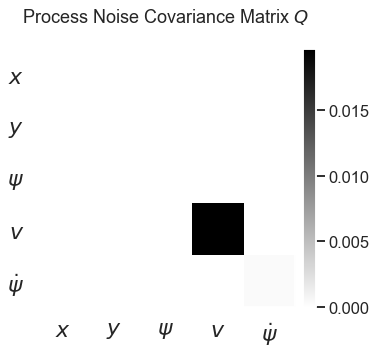

In [193]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$ \n')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(8))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(8))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

### $x$, $y$, and $\psi$ variances are so small they can hardly be seen here.

## Real Measurements

In [194]:
datafile = 'data/2014-03-26-000-Data.csv'

date, \
time, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True,
                  skiprows=1)

print('Read \'%s\' successfully.' % datafile)

# A course of 0° means the Car is traveling north bound
# and 90° means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90°
# We need an offset.
course =(-course+90.0)

Read 'data/2014-03-26-000-Data.csv' successfully.


## Measurement Function H

Matrix $J_H$ is the Jacobian of the Measurement function $h$ with respect to the state. Function $h$ can be used to compute the predicted measurement from the predicted state.

If a GPS measurement is available, the following function maps the state to the measurement.

In [195]:
hs = Matrix([[xs],
             [ys],
             [vs],
             [dpsis]])
hs

Matrix([
[       x],
[       y],
[       v],
[\dot\psi]])

In [196]:
JHs=hs.jacobian(state)

If no GPS measurement is available, simply set the corresponding values in $J_h$ to zero.

## Measurement Noise Covariance $R$

In [197]:
sGPS = 5.0                                     # Standard Deviation of GPS Measurement
sspeed = 2.0                                   # Standard Deviation of the speed measurement
syaw = 0.01                                    # Standard Deviation of the yawrate measurement
R = np.matrix([[sGPS**2, 0.0, 0.0, 0.0],
               [0.0, sGPS**2, 0.0, 0.0],
               [0.0, 0.0, sspeed**2, 0.0],
               [0.0, 0.0, 0.0, syaw**2]])

print(R)

[[2.5e+01 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 2.5e+01 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 4.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 1.0e-04]]


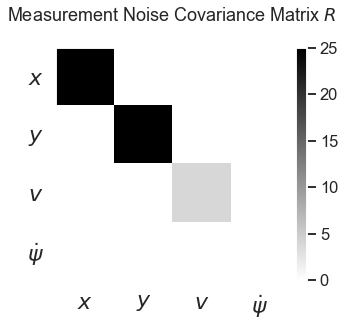

In [198]:
fig = plt.figure(figsize=(4.5, 4.5))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Measurement Noise Covariance Matrix $R$ \n')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(5))
# set the locations and labels of the yticks
plt.yticks(np.arange(4),('$x$', '$y$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(5))
# set the locations and labels of the yticks
plt.xticks(np.arange(4),('$x$', '$y$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

## Identity Matrix

In [199]:
I = np.eye(numstates)

## Approx. Lat/Lon to Meters to check Location

In [200]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter

## Initial State

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

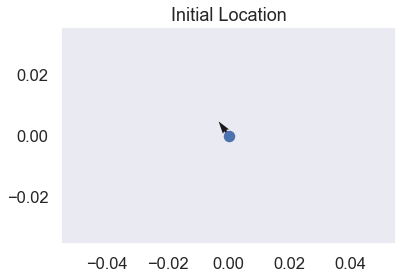

In [201]:
x = np.matrix([[mx[0], my[0], course[0]/180.0*np.pi, speed[0]/3.6+0.001, yawrate[0]/180.0*np.pi]]).T

U=float(np.cos(x[2])*x[3])
V=float(np.sin(x[2])*x[3])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

### Measurement vector

In [202]:
measurements = np.vstack((mx, my, speed/3.6, yawrate/180.0*np.pi))
# Lenth of the measurement
m = measurements.shape[1]

In [203]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
dstate=[]

# Extended Kalman Filter

![Extended Kalman Filter Step](resources/Extended-Kalman-Filter-Step.png)

$$x_k= \begin{bmatrix} x \\ y \\ \psi \\ v \\ \dot\psi \end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate} \end{bmatrix} =  \begin{bmatrix}x[0] \\ x[1] \\ x[2] \\ x[3] \\ x[4]  \end{bmatrix}$$

In [204]:
for filterstep in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    if np.abs(yawrate[filterstep])<0.0001: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[2])
        x[1] = x[1] + x[3]*dt * np.sin(x[2])
        x[2] = x[2]
        x[3] = x[3]
        x[4] = 0.0000001 # avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2]))
        x[1] = x[1] + (x[3]/x[4]) * (-np.cos(x[4]*dt+x[2])+ np.cos(x[2]))
        x[2] = (x[2] + x[4]*dt + np.pi) % (2.0*np.pi) - np.pi
        x[3] = x[3]
        x[4] = x[4]
        dstate.append(1)
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = float((x[3]/x[4]) * (np.cos(x[4]*dt+x[2]) - np.cos(x[2])))
    a14 = float((1.0/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a15 = float((dt*x[3]/x[4])*np.cos(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a23 = float((x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a24 = float((1.0/x[4]) * (-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    a25 = float((dt*x[3]/x[4])*np.sin(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    JA = np.matrix([[1.0, 0.0, a13, a14, a15],
                    [0.0, 1.0, a23, a24, a25],
                    [0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 1.0]])
    
    
    # Project the error covariance ahead
    P = JA*P*JA.T + Q
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[3])],
                    [float(x[4])]])

    if GPS[filterstep]:
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])
    else:
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])        
    
    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))*P


    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))

## Plots

### Uncertainties

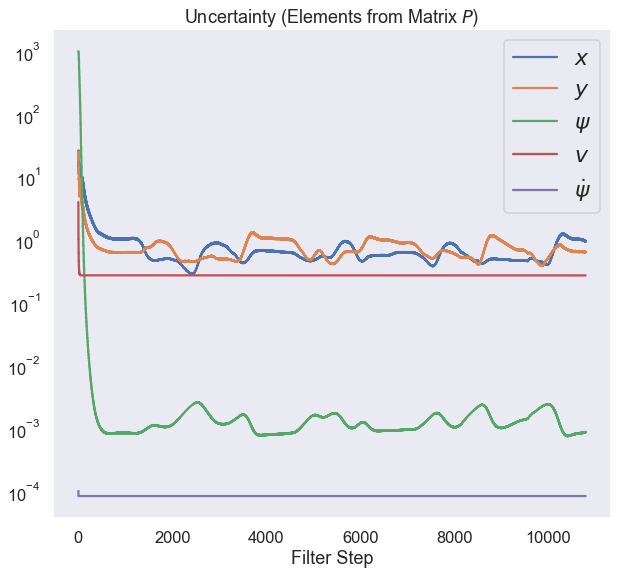

In [205]:
fig = plt.figure(figsize=(fw,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

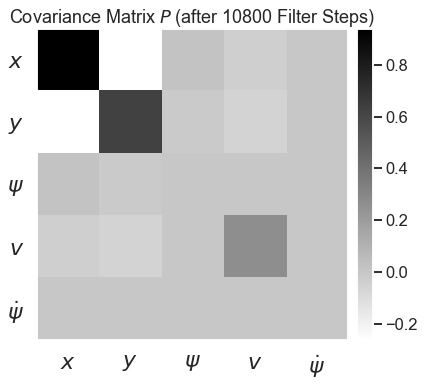

In [206]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

### Kalman Gains

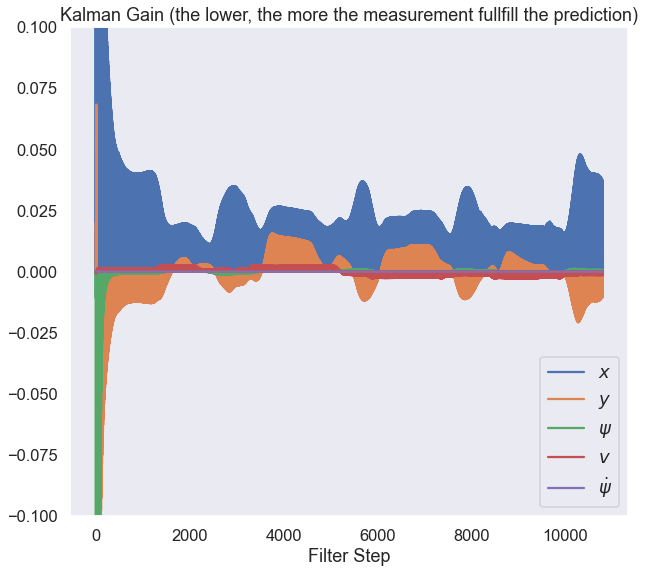

In [207]:
fig = plt.figure(figsize=(fw,9))
plt.step(range(len(measurements[0])),Kx, label='$x$')
plt.step(range(len(measurements[0])),Ky, label='$y$')
plt.step(range(len(measurements[0])),Kdx, label='$\psi$')
plt.step(range(len(measurements[0])),Kdy, label='$v$')
plt.step(range(len(measurements[0])),Kddx, label='$\dot \psi$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.1,0.1]);

## State Vector

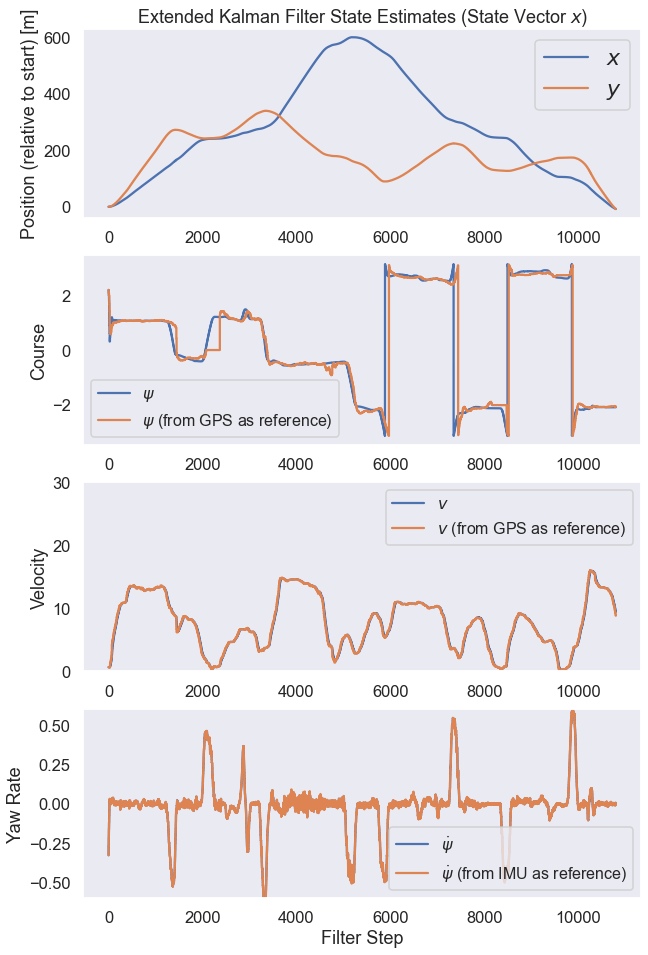

In [208]:
fig = plt.figure(figsize=(fw,16))

plt.subplot(411)
plt.step(range(len(measurements[0])),x0-mx[0], label='$x$')
plt.step(range(len(measurements[0])),x1-my[0], label='$y$')

plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Position (relative to start) [m]')

plt.subplot(412)
plt.step(range(len(measurements[0])),x2, label='$\psi$')
plt.step(range(len(measurements[0])),(course/180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi, label='$\psi$ (from GPS as reference)')
plt.ylabel('Course')
plt.legend(loc='best',prop={'size':16})
           
plt.subplot(413)
plt.step(range(len(measurements[0])),x3, label='$v$')
plt.step(range(len(measurements[0])),speed/3.6, label='$v$ (from GPS as reference)')
plt.ylabel('Velocity')
plt.ylim([0, 30])
plt.legend(loc='best',prop={'size':16})

plt.subplot(414)
plt.step(range(len(measurements[0])),x4, label='$\dot \psi$')
plt.step(range(len(measurements[0])),yawrate/180.0*np.pi, label='$\dot \psi$ (from IMU as reference)')
plt.ylabel('Yaw Rate')
plt.ylim([-0.6, 0.6])
plt.legend(loc='best',prop={'size':16})
plt.xlabel('Filter Step')

## Position x/y

(-38.41234151755903, 632.3215437041752, -25.45213888199942, 358.44116093136176)

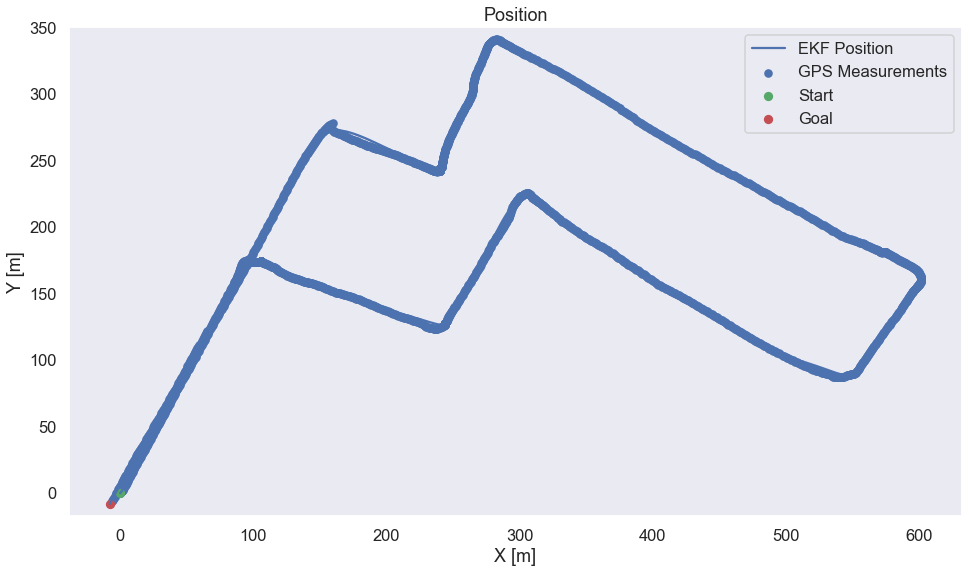

In [210]:
fig = plt.figure(figsize=(16,9))

# EKF State
plt.plot(x0,x1, label='EKF Position')

# Measurements
plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')

### Detailed View

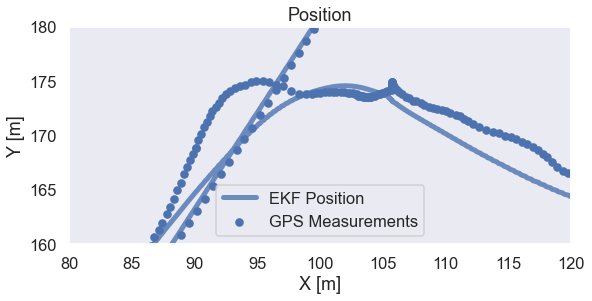

In [211]:
fig = plt.figure(figsize=(9,4))

# EKF State
#plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.01, scale=0.2, label='Driving Direction')
plt.plot(x0,x1, label='EKF Position', linewidth=5, alpha=0.8)

# Measurements
plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements')
#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

plt.xlabel('X [m]')
plt.xlim(80, 120)
plt.ylabel('Y [m]')
plt.ylim(160, 180)
plt.title('Position')
plt.legend(loc='best');
plt.savefig('EKF-Position.png', dpi=150)

# Conclusion

As you can see, complicated analytic calculation of the Jacobian Matrices, but it works pretty well.